# Support Vector Machines（SVM）与 K-Nearest Neighbor（KNN）预测客户流失量

本次课题任务为根据客户流失训练集对测试集文件进行预测。该部分工作主要为分别采用SVM与KNN两种不同方法训练模型，并对客户流失量进行预测。

## Support Vector Machines（SVM）二分类原理简介
支持向量机（Support Vector Machines）是一种二分类分类模型，其基本模型为定义在特征空间上间隔最大的线性分类器，此外，支持向量机还支持核技巧。
支持向量机的学习策略是求解能够正确划分训练数据集并且几何间隔最大的分离超平面，其本质算法为求解凸二次规划的最优化算法。
根据学习方法，支持向量机模型包含线性可分支持向量机、线性支持向量机、非线性支持向量机三大类。当训练数据线性可分时，通过硬间隔最大化学习线性分类器；训练数据近似线性可分时，采用软间隔最大化学习线性分类器（引入松弛变量等）；训练数据线性不可分时，通过核技巧及软间隔最大化学习非线性支持向量机。

下面采用SVM方法实现客户流失数据预测。

In [38]:
# ====== 导入工具库 =======
import csv
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import neighbors
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt


In [39]:
# ========== SVM分类器训练及预测 ===========
def svm_pred(k, x_t, y_t, x_v, y_v, test_data):
    # ====== 训练SVM ========
    # 当核函数为rbf（高斯核函数）时，通过调整参数C和gamma，提高分类器性能
    # rbf，C=0.8，gamma=0.001时达到rbf最佳（测试集上75.82%）
    model = svm.SVC(C=0.8, gamma=0.001, kernel='rbf')
#     # 核函数为linear时，C=0.8时，通过调整参数C，达到linear最佳（测试集上77.81%）
#     model = svm.SVC(C=0.8, gamma=0.001, kernel='linear')

    model.fit(x_t, y_t)
    print(str(k+1) + " fold model score:" + str(model.score(x_t, y_t)))

    # ====== 验证模型精度 ========
    y_v_pred = model.predict(x_v)

    # ====== AUC ROC 绘制 =======
    y_dist = model.decision_function(x_v)
    AucRoc(y_v, y_dist, 'svm', k)

    # ====== 预测客户流失 ========
    x_test = test_data[:, 1:]
    y_pred = model.predict(x_test)
    y_pred.astype(np.int16)
    y_ret = ['Yes' if y_pred[i] == 1 else 'No' for i in range(len(y_pred))]

    np.savetxt("svm_pred.csv", y_ret, fmt='%s')
    return accuracy_score(y_v_pred, y_v)

## K-Nearest Neighbor（KNN）原理简介
k近邻法（K-Nearest Neighbor）是一种基本分类回归方法，k近邻法假设给定一个训练数据集，其中实例类别已定，分类时，对新的实例，根据其k个最近邻的训练实例类别，通过多数表决方式进行预测。k近邻本质是利用训练数据集对特征向量空间进行划分，并作为其分类的“模型”。k值的选择、距离度量、分类决策规则是k近邻法的三个基本要素。

下面采用KNN方法实现客户流失数据预测。

In [40]:
# ========== KNN分类器训练及预测 ===========
def knn_pred(k, x_t, y_t, x_v, y_v, test_data):
    # 训练KNN模型，通过调整参数k（40为最佳结果，测试集上达到75.21%）
    clf = neighbors.KNeighborsClassifier(40)
    clf.fit(x_t, y_t)
    print(str(k+1) + " fold model score:" + str(clf.score(x_t, y_t)))

    # ====== 验证模型精度 ========
    y_v_pred = clf.predict(x_v)

    # ====== AUC ROC 绘制 =======
    y_dist = clf.predict_proba(x_v)[:, 1]
    AucRoc(y_v, y_dist, 'knn', k)

    # ====== 预测客户流失 ========
    x_test = test_data[:, 1:]
    y_pred = clf.predict(x_test)
    y_pred.astype(np.int16)
    y_ret = ['Yes' if y_pred[i] == 1 else 'No' for i in range(len(y_pred))]

    np.savetxt("knn_pred.csv", y_ret, fmt='%s')
    return accuracy_score(y_v_pred, y_v)

## 公共代码部分

In [41]:
# 采用分层五折交叉验证法将数据集进行划分
def kfold_cross(train_data, test_data, method):
    X = train_data[:, 1:-1]
    y = train_data[:, -1]
    skf = StratifiedKFold(n_splits=5).split(X, y)
    val_acc = []

    for k, (train_index, valid_index) in enumerate(skf):
        # print("TRAIN:", train_index, "VALID:", valid_index)
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        if method == 'svm':
            acc = svm_pred(k, X_train, y_train, X_valid, y_valid, test_data)
        elif method == 'knn':
            acc = knn_pred(k, X_train, y_train, X_valid, y_valid, test_data)
        val_acc.append(acc)
        print(method + " " + str(k+1) + " fold acc: " + str(acc) + "\n")

    print(method + " mean acc: " + str(np.mean(val_acc)) + "\n")
    draw_chart(val_acc, method)

In [42]:
# ====== Acc画图函数 =========
def draw_chart(y_label, tit):
    x = [1, 2, 3, 4, 5]
    plt.plot(x, y_label, 'ro-')
    plt.xlabel("K fold")
    plt.ylabel(tit + " Acc")
    plt.ylim(ymax=1.0, ymin=0.5)
    plt.title("Acc of K fold for " + tit)
    name = tit + ".jpg"
    plt.savefig(name)
    plt.show()

# ======== ROC曲线绘制 ========= 
def AucRoc(y_hat, y_pred, tit, k):
    # ====== 计算ROC =======
    fpr, tpr, threshold = roc_curve(y_hat, y_pred)

    # ====== 计算AUC =======
    ras = roc_auc_score(y_hat, y_pred)
    print(str(k+1) + 'fold AUC: ' + str(ras))

    # ======= 绘图 =========
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    roc_tit = str(k+1) + ' fold ' + tit + ' ROC Curve'
    plt.title(roc_tit)
    name = roc_tit + ".jpg"
    plt.savefig(name)
    plt.show()

 ============ SVM ===============
1 fold model score:0.7555608706051183
1fold AUC: 0.7621794871794872


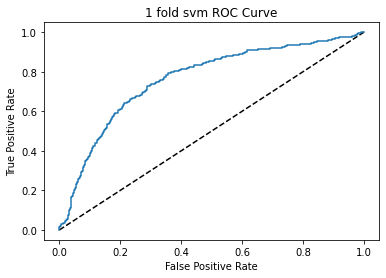

svm 1 fold acc: 0.7237093690248566

2 fold model score:0.7624970102846209
2fold AUC: 0.738365775484678


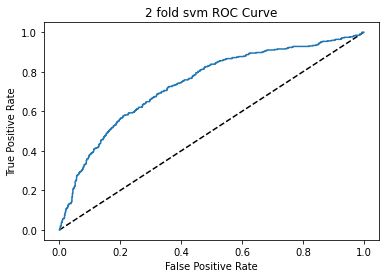

svm 2 fold acc: 0.7112810707456979

3 fold model score:0.7560975609756098
3fold AUC: 0.7592952536209168


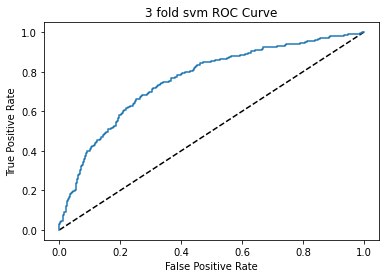

svm 3 fold acc: 0.7138755980861244

4 fold model score:0.763271162123386
4fold AUC: 0.7316367797354066


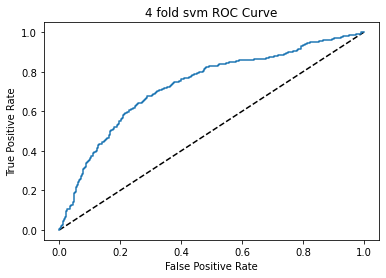

svm 4 fold acc: 0.7052631578947368

5 fold model score:0.7613582018173123
5fold AUC: 0.7718548184839175


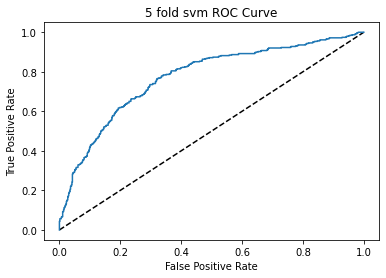

svm 5 fold acc: 0.7291866028708134

svm mean acc: 0.7166631597244459



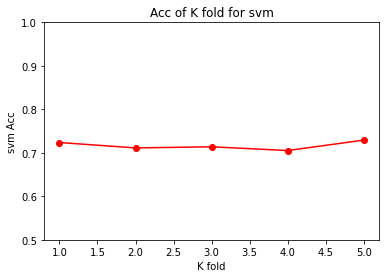

 ============ KNN ===============
1 fold model score:0.7270987801961253
1fold AUC: 0.7762605534709194


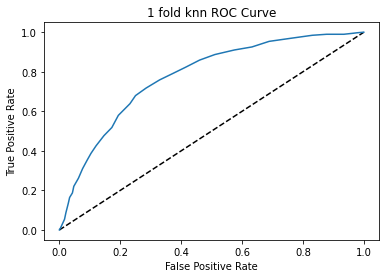

knn 1 fold acc: 0.7131931166347992

2 fold model score:0.7290121980387467
2fold AUC: 0.7444066604127579


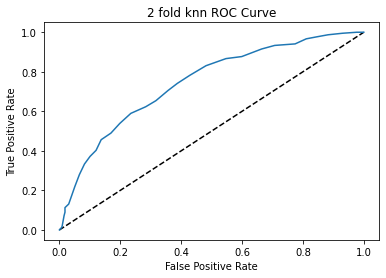

knn 2 fold acc: 0.7112810707456979

3 fold model score:0.7283596365375419
3fold AUC: 0.7629729920371182


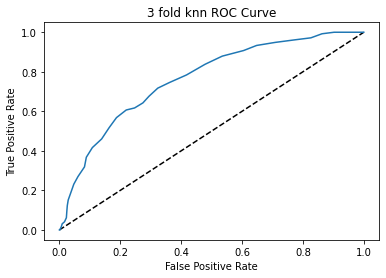

knn 3 fold acc: 0.7177033492822966

4 fold model score:0.7302725968436155
4fold AUC: 0.7449311085334503


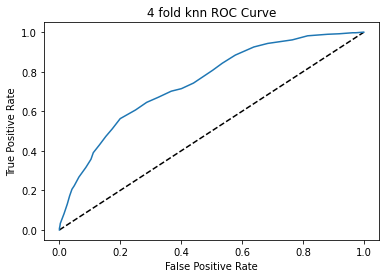

knn 4 fold acc: 0.7081339712918661

5 fold model score:0.7221425155428025
5fold AUC: 0.7748448178569188


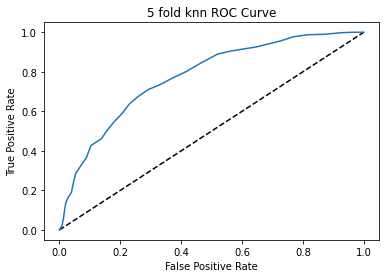

knn 5 fold acc: 0.7167464114832536

knn mean acc: 0.7134115838875827



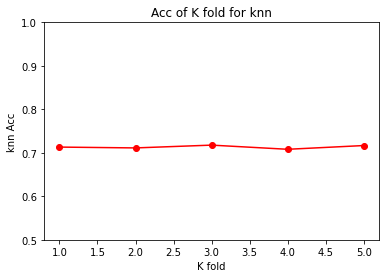

In [43]:
if __name__ == '__main__':
    train_file = 'pro_train.csv'
    test_file = 'pro_test.csv'
    train_data = pd.read_csv(train_file).values
    test_data = pd.read_csv(test_file).values

    # ==========  SVM 预测 ==========
    print(" ============ SVM ===============")
    kfold_cross(train_data, test_data, 'svm')

    # ==========  KNN 预测 ==========
    print(" ============ KNN ===============")
    kfold_cross(train_data, test_data, 'knn')

提交成绩：
1、SVM kernel=linear，C = 0.8，gamma=0.001
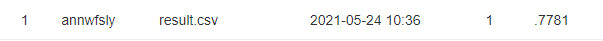

2、SVM kernel=rbf，C=0.8，gamma=0.001


3、KNN k=40
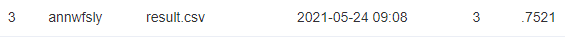